## Pooling

In [27]:
import pandas as pd 
import numpy as np
import arviz as az
import pymc as pm
import palmerpenguins as pp
import scipy.stats as stats
import matplotlib.pyplot as plt

In [28]:
def generate_sales(*, days, mean, std, label):
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    return df

In [29]:
pizza_df = generate_sales(days=365, mean=13, std=5, label="Pizza")
sandwich_df = generate_sales(days=100, mean=6, std=5, label="Sandwich")

salad_days = 3
salad_df = generate_sales(days=salad_days, mean=8 ,std=3, label="Salad")

In [30]:
sales_df = pd.concat([pizza_df, sandwich_df, salad_df]).reset_index(drop=True)
sales_df["Food_Category"] = pd.Categorical(sales_df["Food_Category"])
sales_df

,customers,sales,Food_Category
0,31,459.895203,Pizza
1,31,401.147736,Pizza
2,31,413.345245,Pizza
3,31,371.909241,Pizza
4,32,433.797089,Pizza
...,...,...,...
463,100,611.736816,Sandwich
464,100,667.152954,Sandwich
465,42,331.625702,Salad
466,66,520.900940,Salad


In [31]:
customers = sales_df["customers"].values
sales_observed = sales_df["sales"].values
food_category = pd.Categorical(sales_df["Food_Category"])

In [32]:
with pm.Model() as model:

 sigma = pm.HalfNormal('sigma', 20, shape=3)
 beta = pm.Normal('beta', mu=10, sigma=10, shape=3)

 mu = beta[food_category.codes] * customers

 sales = pm.Normal("sales", mu, sigma[food_category.codes], observed=sales_observed)

 idata = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [33]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata= True)

Sampling: [sales]


array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n0'}>],
       [<AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n1'}>],
       [<AxesSubplot:title={'center':'beta\n2'}>,
        <AxesSubplot:title={'center':'beta\n2'}>],
       [<AxesSubplot:title={'center':'sigma\n0'}>,
        <AxesSubplot:title={'center':'sigma\n0'}>],
       [<AxesSubplot:title={'center':'sigma\n1'}>,
        <AxesSubplot:title={'center':'sigma\n1'}>],
       [<AxesSubplot:title={'center':'sigma\n2'}>,
        <AxesSubplot:title={'center':'sigma\n2'}>]], dtype=object)

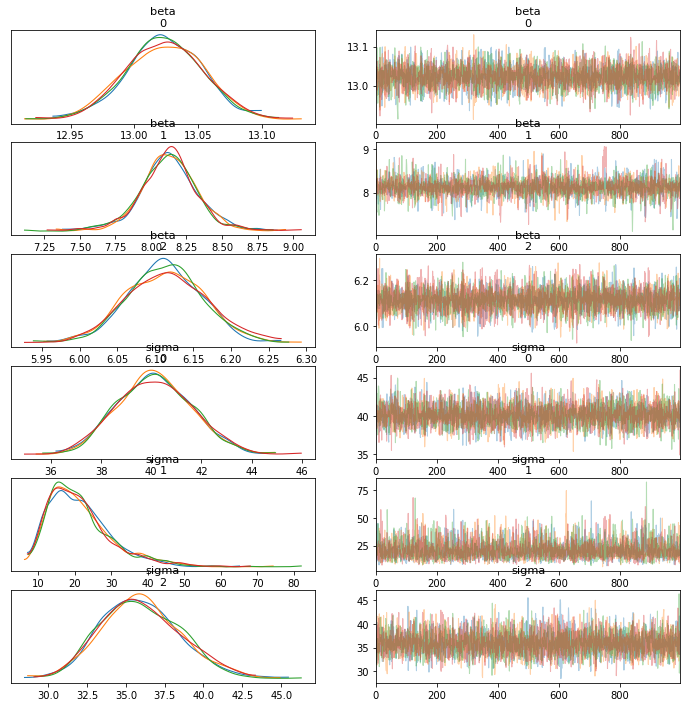

In [35]:
az.plot_trace(idata, var_names=["beta", "sigma"], compact=False)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

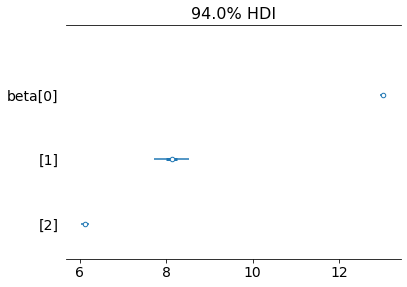

In [38]:
az.plot_forest(idata, var_names=["beta"], combined=True)

### Pooled Model

In [50]:
with pm.Model() as pooled_model:

 sigma = pm.HalfNormal("sigma", 20)
 beta = pm.Normal("beta", mu = 10, sigma = 10)

 mu = pm.Deterministic("mu", beta * customers)

 sales = pm.Normal("sales", mu, sigma, observed=sales_observed)

 idata_pooled = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [51]:
with pooled_model:
    pm.sample_posterior_predictive(idata_pooled, extend_inferencedata= True)

Sampling: [sales]


array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

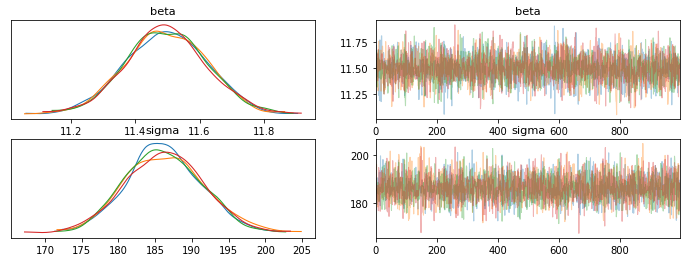

In [52]:
az.plot_trace(idata_pooled, var_names=["beta", "sigma"], compact=False)

In [53]:
az.summary(idata_pooled, var_names=["beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,11.496,0.126,11.263,11.732,0.002,0.001,4010.0,2918.0,1.0
sigma,186.244,5.256,176.250,195.810,0.083,0.058,4068.0,2973.0,1.0
